In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
im_paths = [
    "data/sergem_robocar_20191202/robocar_recording_2019-12-02-17-26-13_6/frame_0000000169.jpg",
    "data/sergem_robocar_20191202/robocar_recording_2019-12-02-17-26-13_6/frame_0000000199.jpg",
    "data/sergem_robocar_20191202/robocar_recording_2019-12-02-17-27-13_7/frame_0000000053.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2016-02-11-17-27-20_f_1/frame_0000000131.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-17-59-38_9.fix/frame_0000000260.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-17-59-38_9.fix/frame_0000000379.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-18-43-52_13_f/frame_0000000154.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-18-43-52_13_f/frame_0000000060.jpg",
    
]



In [3]:
def imread(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Failed to open image '{}'".format(path))
    return img

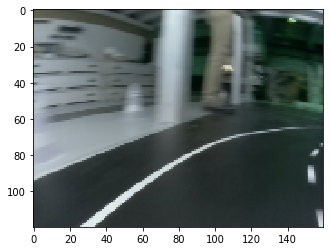

In [50]:
im = imread(im_paths[0])
im_r = cv2.resize(im, dsize=(160,120), interpolation=cv2.INTER_LINEAR)
plt.imshow(im_r)

In [48]:
def process(im, visualize=False, dbg_out=None):
    gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    gray_e = cv2.equalizeHist(gray_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray_image)
    q_low, q_high = np.percentile(cl1, [80, 96])
# #     sigma = 0.99
#     #---- apply automatic Canny edge detection using the computed median----
#     lower = int(max(0, 0.8* v))
#     upper = int(min(255, 1.99 * v))

    edges = cv2.Canny(cl1, q_low, q_high)
    if visualize:
        print(q_low, q_high)
        plt.figure()
        plt.imshow(edges)
        plt.figure()
        plt.imshow(cl1, cmap='gray')
        plt.figure()
        plt.imshow(gray_e, cmap='gray')
        
    
    
    if dbg_out is not None:
        dbg_out.update({'edges': edges, 'gray_e': gray_e, 'cl1':cl1})
        
        
    return edges 

%timeit process(im, visualize=0)

1.1 ms ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


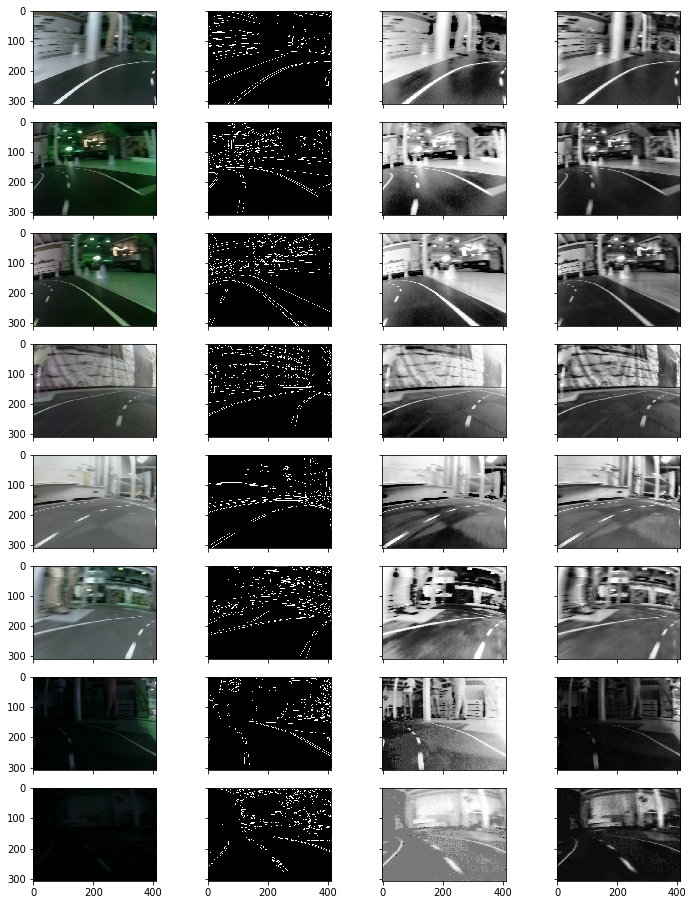

In [51]:

f, ax = plt.subplots(len(im_paths), 4, figsize=(12,16), sharey=True, sharex=True)
for i, path in enumerate(im_paths):
    im = imread(path)
    
    dbg = {}
    res = process(im, dbg_out=dbg)
    ax[i][0].imshow(im)
    for j, (k, v) in enumerate(dbg.items()):
        ax[i][j+1].imshow(v, cmap='gray')
    

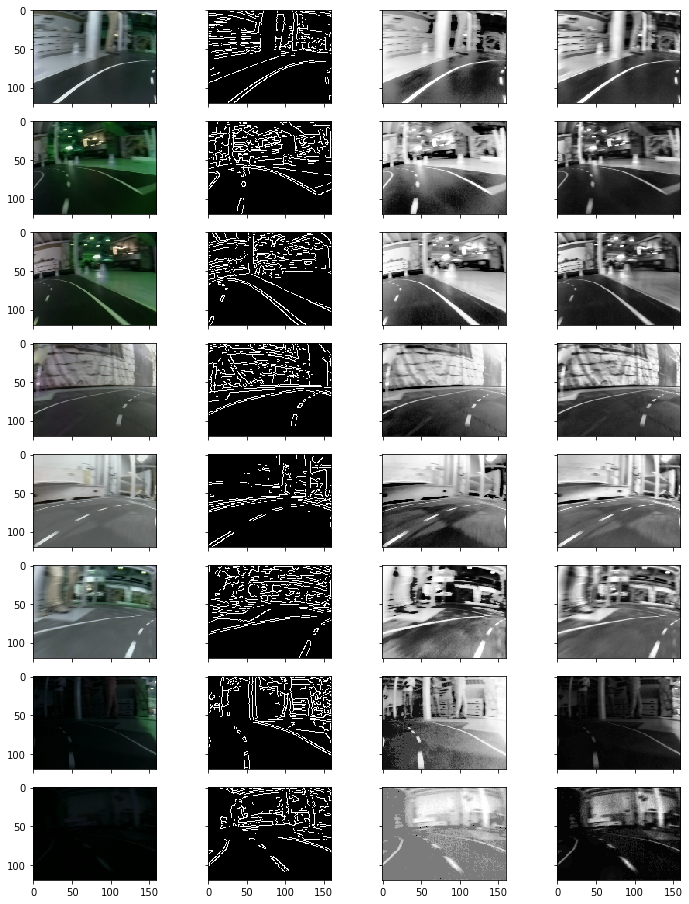

In [53]:

f, ax = plt.subplots(len(im_paths), 4, figsize=(12,16), sharey=True, sharex=True)
for i, path in enumerate(im_paths):
    im = imread(path)
    
    dbg = {}
    im_r = cv2.resize(im, dsize=(160,120), interpolation=cv2.INTER_LINEAR)
    res = process(im_r, dbg_out=dbg)
    ax[i][0].imshow(im_r)
    for j, (k, v) in enumerate(dbg.items()):
        ax[i][j+1].imshow(v, cmap='gray')
    

In [54]:
im.shape

(308, 410, 3)

In [55]:
308/410, 120/160

(0.751219512195122, 0.75)